In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import pickle
import cv2
import numpy as np
from scipy import linalg
from utils_flexit import inception
import torch
from torchvision.transforms import functional as TF
from guided_diffusion.guided_diffusion import dist_util
from sklearn.cluster import KMeans
import blobfile as bf
import torch

In [2]:
base = '/home/miguel/GI/1.5 - Synthetic Data Generation/diffuse-gen/diffuse-gen/image_samples_all'

latest_dir = max(
    (entry for entry in os.scandir(base) if entry.is_dir()),
    key=lambda e: e.stat().st_mtime      # use st_ctime on macOS / Windows if you want “created” time
).path

In [3]:
img_path = max(
    (entry for entry in os.scandir(latest_dir) if entry.is_file() and entry.name.endswith('.pkl') and 'styled' not in entry.name),
    key=lambda e: e.stat().st_mtime
).path

In [4]:
styled_img_path = "/".join(img_path.split('/')[0:-1]) + '/' + img_path.split('/')[-1].replace('samples_', 'styled_samples_')

In [5]:
styled_img_path

'/home/miguel/GI/1.5 - Synthetic Data Generation/diffuse-gen/diffuse-gen/image_samples_all/diffgen-2025-06-18-15-48/styled_samples_110x256x256x4.pkl'

In [6]:
# GAN_path = "/home/daniel/divergent-nets/data/data_files/GAN_dict.pkl"
# img_path = "/home/miguel/GI/1.5 - Synthetic Data Generation/diffuse-gen/diffuse-gen/image_samples/diffgen-2025-06-17-23-26/samples_10x256x256x4.pkl"
# styled_img_path = "/home/miguel/GI/1.5 - Synthetic Data Generation/diffuse-gen/diffuse-gen/image_samples/diffgen-2025-06-17-23-26/styled_samples_10x256x256x4.pkl"
shape = (256, 256)

In [7]:
def shorten_key(key):
    return f".{key.split('diffusion-gen')[1]}"

def load_images_from_path(img_path, mask=False):
    conversion = "RGB" if not mask else "L"
    src_img_pil = Image.open(img_path).convert(conversion)
    src_img_pil = src_img_pil.resize(shape, Image.LANCZOS)  # type: ignore
    src_img = (
        TF.to_tensor(src_img_pil).unsqueeze(0)
    )
    return src_img
def prep_image_for_view(images, n=None):
    paths = []
    images_arr = []
    iters = images.items() if n is None else list(images.items())[:n]
    for path, imgs in iters:
        paths.append(path)
        images_arr.append(imgs)
        batch_size = len(imgs)
    images = np.concatenate(images_arr, axis=0)
    # images = np.load(img_path)['arr_0']
    print(images.shape) # (N, 256, 256, C)
    images, masks = images[..., :3], images[..., 3]
    # Erosion of mask
    threshold = (masks.min() + masks.max()) / 2
    print("Threshold", threshold)
    masks = np.where(masks > threshold, 255, 0).astype(np.uint8)

    return batch_size, images, masks, paths

In [8]:
with open(img_path, "rb") as f:
    images = pickle.load(f)
with open(styled_img_path, "rb") as f:
    styled_images = pickle.load(f)

In [9]:
original_images_folder_path = '/home/miguel/GI/1.5 - Synthetic Data Generation/diffuse-gen/diffuse-gen/guided_diffusion/segmented-images-madison/masked-images'

In [10]:
for filename in os.listdir(original_images_folder_path):
    if filename.endswith('.png'):
        img_path = os.path.join(original_images_folder_path, filename)
        image = Image.open(img_path)
    else:
        continue

In [11]:
from skimage.metrics import structural_similarity as ssim

In [12]:
def compute_ssim_mse(real_roi, synthetic_roi):
    """Compute SSIM and MSE between two ROIs."""
    real_gray = cv2.cvtColor(real_roi.astype(np.uint8), cv2.COLOR_RGB2GRAY).astype(np.uint8)
    synthetic_gray = cv2.cvtColor(synthetic_roi.astype(np.uint8), cv2.COLOR_RGB2GRAY).astype(np.uint8)

    ssim_value = ssim(real_gray, synthetic_gray)
    mse_value = np.mean((real_gray - synthetic_gray) ** 2)
    return ssim_value, mse_value

In [13]:
filename_images = {}
original_sample_filenames = os.listdir(original_images_folder_path)

for filename in original_sample_filenames:
    if filename.endswith('.png'):
        img_path = os.path.join(original_images_folder_path, filename)
        image = Image.open(img_path)
        filename_images[filename] = image
    else:
        continue


In [ ]:
filename_images = {}
original_sample_filenames = os.listdir(original_images_folder_path)

for filename in original_sample_filenames:
    if filename.endswith('.png'):
        img_path = os.path.join(original_images_folder_path, filename)
        image = Image.open(img_path)
        filename_images[filename] = image
    else:
        continue

total_ssim = 0

for key in styled_images.keys():
    styled_image = styled_images[key]
    styled_image = styled_image[0]

    # Split image and mask
    image = styled_image[:, :, :3]  # RGB image (values 0-255)
    mask = styled_image[:, :, 3]    # Single-channel mask (values 0-255)

    # Evaluate SSIM compared to its original base image
    filename = key.split('/')[-1]

    original_image = filename_images[filename]
    original_image = np.array(original_image)
    original_image = cv2.resize(original_image, (256, 256), interpolation=cv2.INTER_LANCZOS4)

    original_image = original_image[:, :, :3]
    original_image = original_image.astype(np.uint8)

    # Convert images to grayscale
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    original_image_gray = cv2.cvtColor(original_image, cv2.COLOR_RGB2GRAY)

    # Calculate SSIM
    image_gray = image_gray.astype(np.uint8)
    original_image_gray = original_image_gray.astype(np.uint8)

    ssim_value = ssim(image_gray, original_image_gray)
    mse_value = np.mean((image_gray - original_image_gray) ** 2)

    total_ssim = total_ssim + ssim_value
mean_ssim = total_ssim / len(styled_images)

KeyError: 'case122_day27_slice_0053.png'

In [48]:
filename

'case122_day27_slice_0053.png'

In [103]:
mean_ssim

np.float64(0.45741279029013493)

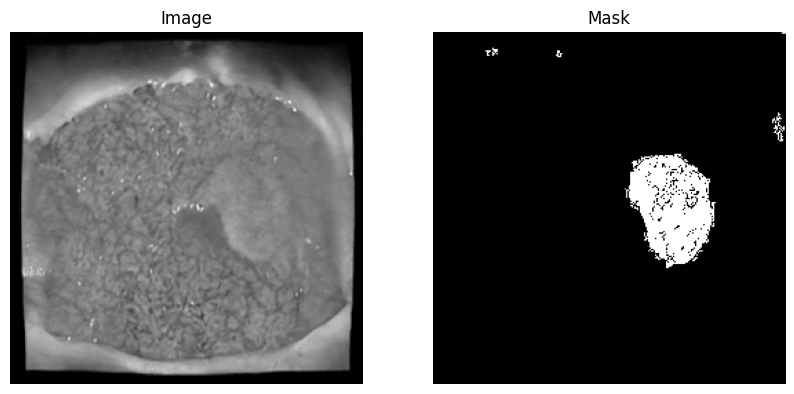

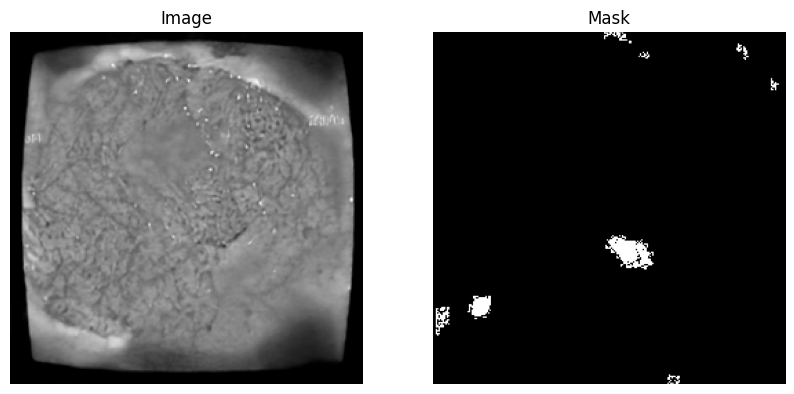

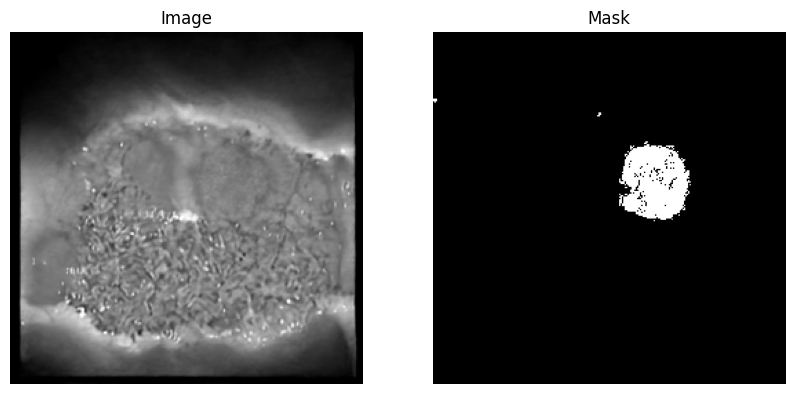

In [44]:
for key in styled_images.keys():
    styled_image = styled_images[key]
    styled_image = styled_image[0]

    # Split image and mask
    image = styled_image[:, :, :3]  # RGB image (values 0-255)
    mask = styled_image[:, :, 3]    # Single-channel mask (values 0-255)

    # Plot them
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Image")
    plt.imshow(image.astype('uint8'))  # Ensure correct dtype
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Mask")
    plt.imshow(mask.astype('uint8'), cmap='gray')  # Show as grayscale
    plt.axis('off')

    plt.show() 


In [ ]:
styled_image = styled_image[0] 

In [35]:
styled_image.flatten().max()

np.uint8(255)

In [29]:
orig_img.shape

torch.Size([1, 3, 256, 256])

In [31]:
orig_mask.shape

torch.Size([1, 3, 256, 256])

AttributeError: 'numpy.ndarray' object has no attribute 'permute'

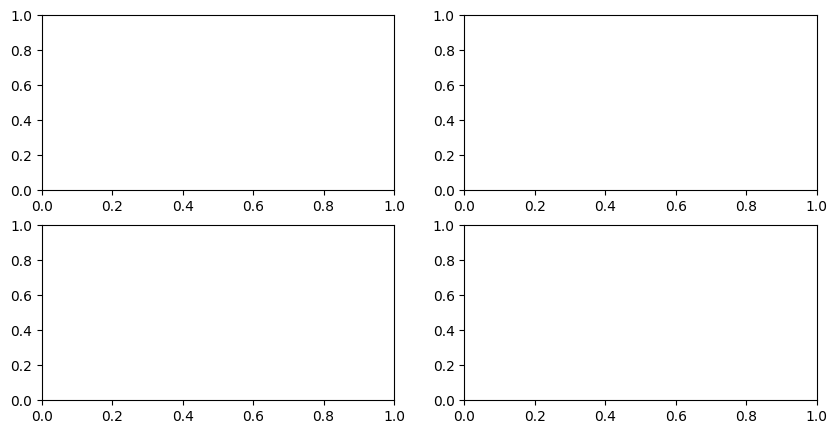

In [27]:

i = list(images.keys())[0]

orig_img = load_images_from_path(i)
orig_mask = load_images_from_path(i.replace("masked-images", "masks"))

fig, ax = plt.subplots(2, 2, figsize=(10, 5))    

# ax[0, 0].imshow(orig_img[0].permute(1, 2, 0))
# ax[0, 0].set_title("Original Image")
# ax[0, 0].axis("off")

# ax[1, 0].imshow(orig_mask[0].permute(1, 2, 0))
# ax[1, 0].set_title("Original Mask")
# ax[1, 0].axis("off")

ax[0, 1].imshow(images[i][0].permute(1, 2, 0))
ax[0, 1].set_title("Inpainted Image")
ax[0, 1].axis("off")

ax[1, 1].imshow(styled_images[i][0])
ax[1, 1].set_title("Styled Image")
ax[1, 1].axis("off")
fig.subplots_adjust(wspace=0, hspace=0)
fig.show()

In [40]:
img_transpose = images[i][0].transpose(2, 0, 1)

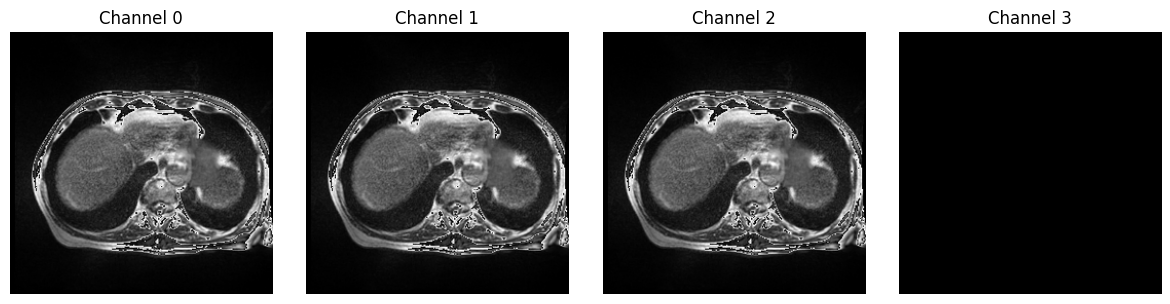

In [41]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i, ax in enumerate(axes):
    ax.imshow(img_transpose[i], cmap='gray')
    ax.set_title(f'Channel {i}')
    ax.axis('off')
plt.tight_layout()
plt.show()

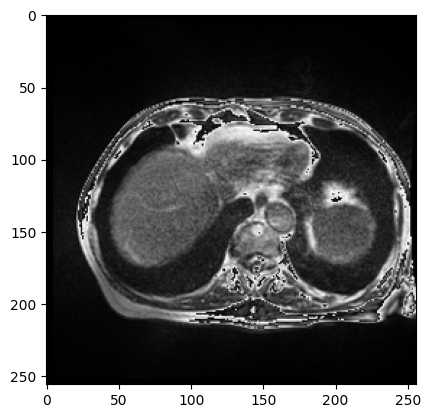

In [44]:
plt.imshow(orig_img[0].permute(1, 2, 0))


In [46]:
orig_img[0].permute(1, 2, 0).sum()

tensor(36568.6289)

(img_transpose[0] / 255)

In [61]:
(img_transpose[0] / 255).sum()

np.float64(12147.06274509804)

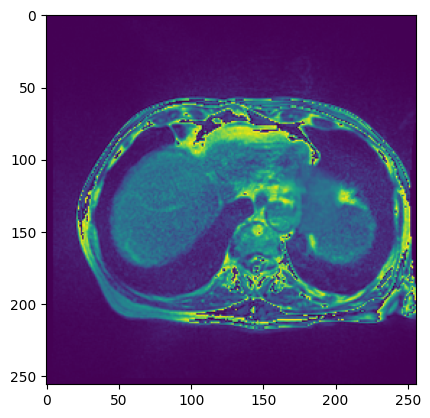

In [63]:
plt.imshow(img_transpose[0])

In [31]:
def show_image(img_path, styled_img_path):
    with open(img_path, "rb") as f:
        images = pickle.load(f)
    with open(styled_img_path, "rb") as f:
        styled_images = pickle.load(f)
    """
    images is a dictionary: {img_path: generated images}
    generated images has shape (N, 256, 256, 4)
    """
    print('len images', len(images))
    iter = min(len(images), 4)
    batch_size, images, masks, paths = prep_image_for_view(images, iter)
    _, styled_images, styled_masks, _ = prep_image_for_view(styled_images, iter)
    # kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (16, 16))
    # ppmask = cv2.morphologyEx(masks[0], cv2.MORPH_OPEN, kernel)
    # plt.imshow(ppmask, cmap="gray")
    #plt.imshow(images[-1])
    # images = [Image.fromarray(np.uint8(img)) for img in images]
    # masks = [Image.fromarray(np.uint8(m)) for m in mask]
    for i in range(iter):
        print('Index', i)
        # Denoise image
        # img =  cv2.fastNlMeansDenoisingColored(np.array(img), None, 10, 10, 7, 21)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # img = Image.fromarray(img)
        # Save the image
        # img.save(f"{img_dir}/{i}.png")
        # masks[i].save(f"{img_dir}/{i}_mask.png")
        # Set axis off

        print('paths', paths)

        path = shorten_key(paths[i // batch_size])
        # path = paths[i // batch_size]
        orig_img = load_images_from_path(path)
        orig_mask = load_images_from_path(path.replace("masked-images", "masks"))
        print(bf.basename(paths[i // batch_size]))

        # w, h = 3, 3
        # dpi = 512
        # Plot original image, inpainted image, styled image, then masks below
        fig, ax = plt.subplots(2, 3, figsize=(10, 5), frameon=False)    
        ax[0, 0].imshow(orig_img[0].permute(1, 2, 0))
        # ax[0, 0].set_title("Original Image")
        ax[0, 0].axis("off")
        ax[0, 1].imshow(images[i])
        # ax[0, 1].set_title("Inpainted Image")
        ax[0, 1].axis("off")
        ax[0, 2].imshow(styled_images[i])
        # ax[0, 2].set_title("Styled Image")
        ax[0, 2].axis("off")
        ax[1, 0].imshow(orig_mask[0].permute(1, 2, 0))
        # ax[1, 0].set_title("Original Mask")
        ax[1, 0].axis("off")
        ax[1, 1].imshow(masks[i], cmap="gray")
        # ax[1, 1].set_title("Inpainted Mask")
        ax[1, 1].axis("off")
        ax[1, 2].imshow(styled_masks[i], cmap="gray")
        # ax[1, 2].set_title("Styled Mask")
        ax[1, 2].axis("off")
        fig.subplots_adjust(wspace=0, hspace=0)


In [32]:
show_image(img_path, styled_img_path)

len images 10
(4, 256, 256, 4)
Threshold 127.5
(4, 256, 256, 4)
Threshold 3.5
Index 0
paths ['/home/miguel/GI/1.5 - Synthetic Data Generation/diffuse-gen/diffuse-gen/guided_diffusion/segmented-images/masked-images/cju0qkwl35piu0993l0dewei2.jpg', '/home/miguel/GI/1.5 - Synthetic Data Generation/diffuse-gen/diffuse-gen/guided_diffusion/segmented-images/masked-images/cju0qoxqj9q6s0835b43399p4.jpg', '/home/miguel/GI/1.5 - Synthetic Data Generation/diffuse-gen/diffuse-gen/guided_diffusion/segmented-images/masked-images/cju0qx73cjw570799j4n5cjze.jpg', '/home/miguel/GI/1.5 - Synthetic Data Generation/diffuse-gen/diffuse-gen/guided_diffusion/segmented-images/masked-images/cju0roawvklrq0799vmjorwfv.jpg']


/tmp/ipykernel_3093288/2793542675.py:25: RuntimeWarning: overflow encountered in scalar add
  threshold = (masks.min() + masks.max()) / 2


IndexError: list index out of range

In [15]:
show_image(styled_img_path)

TypeError: show_image() missing 1 required positional argument: 'styled_img_path'

In [ ]:
# Names of the form chk_id_1_gen_scale_0_0_img.png
def preproces_GAN_images(lst):
    """
    First we want to keep only the first 348 images from the list. We then construct a dictionary of the form {img: list samples of img}
    """
    res = {}
    masked_res = {}
    for i in range(len(lst)):
        split = lst[i].split("_")
        id = int(split[2])
        if id <= 348:
            split[6] = "0"
            key = "_".join(split)
            mask_key = key.replace("img", "mask")
            res[key] = []
            masked_res[mask_key] = []
            for j in range(5):
                split[6] = str(j)
                # Check if in lst
                if "_".join(split) in lst:
                    res[key].append("_".join(split))
                    masked_res[mask_key].append("_".join(split).replace("img", "mask"))
                else:
                    print(f"Missing image: {'_'.join(split)}")
        else:
            break
    return res, masked_res

In [ ]:
lst = os.listdir("../../data/synthetic_polyps_and_masks_10k_split/images")
# Sort lst based on split[2]
lst.sort(key=lambda x: (int(x.split("_")[2]), int(x.split("_")[6])))
res, masked_res = preproces_GAN_images(lst)

In [ ]:
print(len(res), len(masked_res))
print(list(res.keys())[0])
print(list(masked_res.keys())[0])
print(res[list(res.keys())[0]])

In [ ]:
rand_file = "./guided_diffusion/segmented-images/masked-images/cju2yyhsp933j0855hp32e012.jpg"
mask_path = bf.join(bf.dirname(bf.dirname(rand_file)), 'masks', bf.basename(rand_file))

print("Chosen file:", bf.basename(rand_file))
image_size = (256, 256)
target_image_pil = Image.open(rand_file).convert("RGB")
target_mask_pil = Image.open(mask_path).convert("L")
target_image_pil = target_image_pil.resize(image_size, Image.LANCZOS)
target_mask_pil = target_mask_pil.resize(image_size, Image.LANCZOS)

# Dilate mask
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
mask_arr = np.array(target_mask_pil)
mask_arr = np.where(mask_arr > 0, 1, 0).astype(np.uint8)
dilated_mask = cv2.dilate(mask_arr, kernel, iterations=1)
target_mask_pil = Image.fromarray(dilated_mask.astype(np.float64))

target_image = (
    TF.to_tensor(target_image_pil).unsqueeze(0).mul(2).sub(1)
)
#target_mask = TF.to_tensor(target_mask_pil)
target_mask = (
    TF.to_tensor(target_mask_pil).unsqueeze(0).mul(2).sub(1)
)
# Print shapes and extrema
print(target_image.shape, target_mask.shape)
print(target_image.min(), target_image.max())
print(target_mask.min(), target_mask.max())

In [ ]:
with open("/home/daniel/divergent-nets/data/data_files/cc_samples_dil.pkl", "rb") as f:
    sample = pickle.load(f)

In [ ]:
# Look through 10 images at a time, starting from {s}
s = 210
idxs = list(range(s, s + 10))
for idx in idxs:
    path, imgs = list(sample.items())[idx]
    ims, masks = imgs[..., :3], imgs[..., 3]
    # threshold = 127
    # masks = np.where(masks > threshold, 255, 0).astype(np.uint8)
    img, mask = ims[0], masks[0]
    # kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (16, 16))
    # mask = cv2.morphologyEx(masks[0], cv2.MORPH_OPEN, kernel)
    w, h = 3, 3
    dpi = 256
    # Plot image and mask side by side
    fig = plt.figure(figsize=(w, h), dpi=dpi, frameon=False)
    ax = fig.add_subplot(1, 2, 1)
    # Reduce the blue channel
    #img[..., 2] = np.where(img[..., 2] > 128, 100, img[..., 2])
    ax.imshow(img)
    ax.axis("off")
    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(mask, cmap="gray")
    ax.axis("off")
    print(idx)

In [ ]:
def get_matching_orig(img_path):
    # output_images_zip/cluster_styled_samples/images/cju5f26ebcuai0818xlwh6116_sample_0.jpg -> ./guided_diffusion/segmented-images/masked-images/cju5f26ebcuai0818xlwh6116.jpg

    # Get the id
    split = img_path.split("/")[-1]
    split = split.split("_")
    id = split[0]
    # Get the original image
    orig_img_path = f"./guided_diffusion/segmented-images/masked-images/{id}.jpg"
    return orig_img_path

def _list_image_files_recursively(data_dir):
    results = []
    for entry in sorted(bf.listdir(data_dir)):
        full_path = bf.join(data_dir, entry)
        ext = entry.split(".")[-1]
        if "." in entry and ext.lower() in ["jpg", "jpeg", "png", "gif"]:
            results.append(full_path)
        elif bf.isdir(full_path):
            results.extend(_list_image_files_recursively(full_path))
    return results

def form_dict(data_dir):
    res = {}
    for img_path in _list_image_files_recursively(data_dir):
        img = load_images_from_path(img_path)
        mask_path = img_path.replace("images", "masks")
        mask = load_images_from_path(mask_path, mask=True)
        concat_img = np.concatenate((img, mask), axis=1)
        # Transpose
        concat_img = np.transpose(concat_img, (0, 2, 3, 1))
        orig_img_path = get_matching_orig(img_path)
        # print(orig_img_path)
        # print(img_path)
        # print(mask_path)
        # print(concat_img.shape)
        # print(orig_img_path)
        if orig_img_path in res:
            res[orig_img_path] = np.concatenate((res[orig_img_path], concat_img), axis=0)
        else:
            res[orig_img_path] = concat_img
        
    return res

samples = form_dict("./output_imgs_zip/cluster_samples/images")
styled_samples = form_dict("./output_imgs_zip/cluster_styled_samples/images")

In [ ]:
print(len(samples), len(styled_samples))
print(list(samples.keys())[:5])
print(list(samples.values())[0].shape, list(styled_samples.values())[0].shape)

In [ ]:
"""For the samples in cluster_samples0, we want to combine them into one pkl file"""

# Replace this with cluster_samples1, 2
base_dir = "./cluster_samples2/"
# Replace samples, styled_samples with loaded cc_samples, cc_styled_samples
with open("./cluster_samples1/cc_samples.pkl", "rb") as f:
    samples = pickle.load(f)
with open("./cluster_samples1/cc_styled_samples.pkl", "rb") as f:
    styled_samples = pickle.load(f)
# samples = {}
# styled_samples = {}
# If starting from scratch, samples, styled_samples are empty dictionaries

# Shorten the keys: /gpfs/fs1/home/p/ptyrrell/saragihd/diffusion-gen/guided_diffusion/segmented-images/masked-images/cju0s690hkp960855tjuaqvv0.jpg -> ./guided_diffusion/segmented-images/masked-images/cju0s690hkp960855tjuaqvv0.jpg
def find_largest_sampling(base_dir):
    largest = 0
    for file in os.listdir(base_dir):
        if file.endswith(".pkl"):
            idx = 2 if file.startswith("styled") else 1
            size = int(file.split("_")[idx].split("x")[0])
            if size > largest:
                largest = size
    return largest

def shorten_key(key):
    return f".{key.split('diffusion-gen')[1]}"

# Purpose: We sample three images for each source image. We want to combine all the samples into one dictionary
# So the entries in the dictionary are {source_image: samples} where samples is a numpy array of shape (3, 256, 256, 4)
# 3 because we sample 3 images for each source image
n_folders = 0
for folder in os.listdir(base_dir):
    if not os.path.isdir(f"{base_dir}{folder}"): continue
    largest = 0
    n_folders += 1
    for file in os.listdir(f"{base_dir}{folder}"):
        largest = find_largest_sampling(f"{base_dir}{folder}")
        # Only open if its the largest sample file.
        # e.g. there may be samples_50x256x256x4.pkl and samples_100x256x256x4.pkl
        # We only want to open the latter
        idx = 2 if file.startswith("styled") else 1
        if file.endswith(".pkl") and file.split("_")[idx].split("x")[0] == str(largest):
            with open(f"{base_dir}{folder}/{file}", "rb") as f:
                pkl_dict = pickle.load(f)
                if file.startswith("styled"): 
                    out = styled_samples
                else: 
                    out = samples
                for key in pkl_dict:
                    shortened = shorten_key(key)
                    if shortened not in out:
                        out[shortened] = pkl_dict[key] # np array
                    else:
                        out[shortened] = np.concatenate((out[shortened], pkl_dict[key]), axis=0)
                        

print(n_folders)
print(len(samples), len(styled_samples))
print(list(samples.keys())[:5])
print(list(samples.values())[0].shape, list(styled_samples.values())[0].shape)


In [ ]:
with open(f"{base_dir}cc_samples.pkl", "wb") as f:
    pickle.dump(samples, f)
with open(f"{base_dir}cc_styled_samples.pkl", "wb") as f:
    pickle.dump(styled_samples, f)

In [ ]:
base_dir = "./cluster_samples2/"
pkl_path = f"{base_dir}cc_styled_samples"
with open(f"{pkl_path}.pkl", "rb") as f:
    samples = pickle.load(f)

out = {}
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (16, 16))
for path, img_and_mask in samples.items():
    imgs, masks = img_and_mask[..., :3], img_and_mask[..., 3]
    masks = np.where(masks > 127, 255, 0).astype(np.uint8)
    res_masks = []
    for mask in masks:
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        res_masks.append(mask)
    res_masks = np.stack(res_masks, axis=0)
    out[path] = np.concatenate([imgs, res_masks[..., None]], axis=-1)

print(len(out))
print(list(samples.values())[0].shape)


In [ ]:
with open(f"{pkl_path}_dil.pkl", "wb") as f:
    pickle.dump(out, f)
    

In [ ]:
with open("/home/daniel/divergent-nets/data/data_files/cc_styled_samples_dil.pkl", "rb") as f:
    out = pickle.load(f)
base_img = list(out.values())[19]
img1 = base_img[0]
img2 = base_img[1]
img3 = base_img[2]
# Plot side by side
w, h = 6, 3
dpi = 512

fig = plt.figure(figsize=(w, h), dpi=dpi, frameon=False)

ax = fig.add_subplot(2, 3, 1)
ax.imshow(img1[..., :3])
ax.axis("off")
ax = fig.add_subplot(2, 3, 2)
ax.imshow(img2[..., :3])
ax.axis("off")
ax = fig.add_subplot(2, 3, 3)
ax.imshow(img3[..., :3])
ax.axis("off")
# Plot masks
ax = fig.add_subplot(2, 3, 4)
ax.imshow(img1[..., 3], cmap="gray")
ax.axis("off")
ax = fig.add_subplot(2, 3, 5)
ax.imshow(img2[..., 3], cmap="gray")
ax.axis("off")
ax = fig.add_subplot(2, 3, 6)
ax.imshow(img3[..., 3], cmap="gray")
ax.axis("off")
plt.show()

## Plotting below moved to separate notebook

In [ ]:
def load_samples(img_path, idx=None):
    with open(img_path, "rb") as f:
        images = pickle.load(f)
    paths = []
    images_arr = []
    for path, imgs in images.items():
        choice = np.expand_dims(imgs[idx], axis=0) if idx is not None else imgs
        paths.extend([path] * len(choice))
        images_arr.append(choice)
    images = np.concatenate(images_arr, axis=0)
    # images = np.load(img_path)['arr_0']
    images, masks = images[..., :3], images[..., 3]
    images = torch.tensor(images.transpose(0, 3, 1, 2)).float()
    masks = torch.tensor(masks).unsqueeze(1).float()
    # If GAN images, remove this division
    # images = images / 255.0
    # masks = masks / 255.0
    print(images.shape)
    return images, masks, paths

def load_GAN_images_from_dict(res, masked_res, k=0):
    base_dir = "/home/daniel/diff-seg/synthetic_polyps_and_masks_10k_split"
    images = []
    masks = []

    for key, val in res.items():
        if len(val) > 0:
            img_path = bf.join(base_dir, "images", val[k])
            mask_key = key.replace("img", "mask")
            mask_path = bf.join(base_dir, "masks", masked_res[mask_key][k])
            # Open image

            image_pil = Image.open(img_path).convert("RGB")
            image_pil = image_pil.resize(shape, Image.LANCZOS)
            image = (
            TF.to_tensor(image_pil).unsqueeze(0)
            )
            images.append(image)
            mask_pil = Image.open(mask_path).convert("L")
            mask_pil = mask_pil.resize(shape, Image.LANCZOS)
            mask = (
                TF.to_tensor(mask_pil).unsqueeze(0)
            )
            masks.append(mask)
    images = torch.cat(images, dim=0)
    masks = torch.cat(masks, dim=0)
    return images, masks

# Load source images
def _list_image_files_recursively(data_dir):
    results = []
    for entry in sorted(bf.listdir(data_dir)):
        full_path = bf.join(data_dir, entry)
        ext = entry.split(".")[-1]
        if "." in entry and ext.lower() in ["jpg", "jpeg", "png", "gif"]:
            results.append(full_path)
        elif bf.isdir(full_path):
            results.extend(_list_image_files_recursively(full_path))
    return results

def load_images_from_dir(dir_path="./guided_diffusion/segmented-images/masked-images", n=None):
    src_path = dir_path

    src_image_paths = _list_image_files_recursively(src_path)
    if n is not None:
        src_image_paths = src_image_paths[:n]
    src_images = []
    for path in src_image_paths:
        src_img_pil = Image.open(path).convert("RGB")
        src_img_pil = src_img_pil.resize(shape, Image.LANCZOS)  # type: ignore
        src_img = (
            TF.to_tensor(src_img_pil).unsqueeze(0)
        )
        src_images.append(src_img)

    src_images = torch.cat(src_images, dim=0).float()
    print(src_images.shape)
    return src_images


In [ ]:
def save_GAN_dict(res, masked_res):
    image_files = _list_image_files_recursively("./guided_diffusion/segmented-images/masked-images")
    GAN_image_files = list(res.keys())
    GAN_image_files.sort(key=lambda x: int(x.split("_")[2]))
    # Replace keys
    out = {}
    base_dir = "../../data/synthetic_polyps_and_masks_10k_split"
    
    for key, val in res.items():
        images = []
        masks = []
        if len(val) > 0:
            for k in range(len(val)):
                img_path = bf.join(base_dir, "images", val[k])
                mask_key = key.replace("img", "mask")
                mask_path = bf.join(base_dir, "masks", masked_res[mask_key][k])
                # Open image

                image_pil = Image.open(img_path).convert("RGB")
                image_pil = image_pil.resize(shape, Image.LANCZOS)
                image = (
                TF.to_tensor(image_pil).unsqueeze(0)
                )
                images.append(image)
                mask_pil = Image.open(mask_path).convert("L")
                mask_pil = mask_pil.resize(shape, Image.LANCZOS)
                mask = (
                    TF.to_tensor(mask_pil).unsqueeze(0)
                )
                masks.append(mask)
        images = torch.cat(images, dim=0).numpy()
        images = images.transpose(0, 2, 3, 1)
        masks = torch.cat(masks, dim=0).numpy()
        masks = masks.transpose(0, 2, 3, 1)
        # print(images.shape, masks.shape)
        idx = GAN_image_files.index(key)
        out[image_files[idx]] = np.concatenate([images, masks], axis=-1)

    print(list(out.keys())[:5])
    print(list(out.values())[0].shape)
    with open("./GAN_dict.pkl", "wb") as f:
        pickle.dump(out, f)
_ = save_GAN_dict(res, masked_res)

In [ ]:
images, masks, paths = load_samples("./GAN_dict.pkl", 1)

In [ ]:
src_images = load_images_from_dir(n=5)
src_masks = load_images_from_dir(dir_path="./guided_diffusion/segmented-images/masks", n=5)

In [ ]:
plt.imshow(src_images[0].permute(1, 2, 0).numpy())

In [ ]:
plt.imshow(images[0].permute(1, 2, 0))

In [ ]:
with open("/home/daniel/divergent-nets/data/data_files/cc_samples_dil.pkl", "rb") as f:
        images = pickle.load(f)

with open("/home/daniel/divergent-nets/data/data_files/cc_styled_samples_dil.pkl", "rb") as f:
        styled_images = pickle.load(f)
# Plot images on first row, mask on second
# idxs = 59, 338, 342, 211
idx = 211
path, imgs = list(images.items())[idx]
path, styled_imgs = list(styled_images.items())[idx]
fig = plt.figure(figsize=(10, 5), frameon=False)
# paths.extend([path])
# imgs shape (N, 256, 256, 4)
ims, masks = imgs[..., :3], imgs[..., 3]
styled_ims, _ = styled_imgs[..., :3], styled_imgs[..., 3]
# Plot imgs above masks
original_image = os.path.join("./guided_diffusion/segmented-images/masked-images", bf.basename(path))
original_image_pil = Image.open(original_image).convert("RGB")
original_image_pil = original_image_pil.resize(shape, Image.LANCZOS)
original_mask = os.path.join("./guided_diffusion/segmented-images/masks", bf.basename(path))
original_mask_pil = Image.open(original_mask).convert("L")
original_mask_pil = original_mask_pil.resize(shape, Image.LANCZOS)
plot_length = len(ims) + 1

ax = fig.add_subplot(2, plot_length, 1)
ax.imshow(np.array(original_image_pil))
ax.axis("off")
# ax = fig.add_subplot(2, plot_length, plot_length + 1)
# ax.imshow(np.array(original_mask_pil), cmap="gray")
# ax.axis("off")
for i in range(1, plot_length):
        ax = fig.add_subplot(2, plot_length, i + 1)
        ax.imshow(ims[i-1])
        ax.axis("off")
        ax = fig.add_subplot(2, plot_length, plot_length + i + 1)
        # ax.imshow(masks[i-1], cmap="gray")
        ax.imshow(styled_ims[i - 1])
        ax.axis("off")
        
# Leave no space between subplots
fig.subplots_adjust(wspace=0, hspace=0)
plt.savefig(f"figures/styled{idx}.png")
plt.show()


In [ ]:
# Display src_images, src_masks. Images in first row, masks in second row

def show_data():
    # Tight layout
    fig = plt.figure(figsize=(16, 7), dpi=100, tight_layout=True, frameon=False)
    # Add tight gridspec
    gs = fig.add_gridspec(2, 5, wspace=0, hspace=0)

    
    for i in range(5):
        ax = fig.add_subplot(gs[0, i])
        ax.imshow(src_images[i].permute(1, 2, 0))
        ax.axis("off")
        ax = fig.add_subplot(gs[1, i])
        ax.imshow(src_masks[i].permute(1, 2, 0))
        ax.axis("off")
show_data()

In [ ]:
# Setup dataloader
batch_size = 3
dataset = torch.utils.data.TensorDataset(src_images, src_images)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [ ]:
len(dataloader)

## Clustering moved to separate notebook

In [ ]:
# Cluster the images based on inception features
def ret_img_mask(img_path):
    img_dir = bf.dirname(bf.dirname(img_path))
    mask_dir = bf.join(img_dir, "masks")

    mask_path = bf.join(mask_dir, bf.basename(img_path))

    img = Image.open(img_path).convert("RGB")
    img = img.resize(shape, Image.LANCZOS)
    mask = Image.open(mask_path).convert("RGB")
    mask = mask.resize(shape, Image.LANCZOS)
    arr = np.array(img)
    mask_arr = np.array(mask)
    return arr, mask_arr


def get_inception_features(img_paths):
    dist_util.setup_dist()
    inception_model = inception.InceptionV3()
    inception_model = inception_model.to(dist_util.dev())

    inception_model.eval()
    inception_model.requires_grad_(False)
    features_map = {}

    for path in img_paths:
        # Since inception only takes 3 channel inputs, we append the mask features to the image features
        img, mask = ret_img_mask(path)
        img, mask = TF.to_tensor(img).unsqueeze(0), TF.to_tensor(mask).unsqueeze(0)
        img, mask = img.to(dist_util.dev()), mask.to(dist_util.dev())
        feat = inception_model(img).squeeze().detach().cpu().numpy()
        mask_feat = inception_model(mask).squeeze().detach().cpu().numpy()
        feat = np.concatenate([feat, mask_feat], axis=0)

        features_map[path] = feat
    return features_map

def create_clusters(features_map, num_clusters=10):
    features = np.array(list(features_map.values()))
    paths = np.array(list(features_map.keys()))
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(features)
    clusters = {}
    for i in range(num_clusters):
        clusters[i] = paths[kmeans.labels_ == i]
    return clusters

In [ ]:
path = src_image_paths[0]
print(path)
img, mask = ret_img_mask(path)
fig = plt.figure(figsize=(10, 10), dpi=100, frameon=False)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(img)
ax = fig.add_subplot(1, 2, 2)
ax.imshow(mask)

In [ ]:
# features_map = get_inception_features(src_image_paths)
# print(len(features_map))
# print(len(features_map[src_image_paths[0]]))

In [ ]:
n_clusters=20
#clusters = create_clusters(features_map, num_clusters=n_clusters)
with open('./clusters.pkl', 'rb') as f:
    clusters = pickle.load(f)

In [ ]:
# Length of each cluster
[len(clusters[i]) for i in range(n_clusters)]

In [ ]:
# Sample images from the clusters
def sample_images_from_clusters(clusters, num_samples=1):
    for j, cluster in enumerate(clusters.values()):
        # if j != 2:
        #     continue
        paths = np.random.choice(cluster, num_samples if num_samples < len(cluster) else len(cluster), replace=False)
        # Plot images in the same cluster in the same figure
        w, h = 3, 3
        dpi = 512
        fig = plt.figure(figsize=(w, h), dpi=dpi, frameon=False)
        for i, path in enumerate(paths):
            ax = fig.add_subplot(1, num_samples, i + 1)
            img = Image.open(path).convert("RGB")
            img = img.resize(shape, Image.LANCZOS)
            ax.imshow(img)
            ax.axis("off")
        # set title
        plt.show()

sample_images_from_clusters(clusters, num_samples=5)

In [ ]:
# Save clusters as pkl
with open("./clusters.pkl", "wb") as f:
    pickle.dump(clusters, f)